<a href="https://colab.research.google.com/github/GruAna/VU/blob/master/Copy_of_keras_ocr_born_digital_public_tuning_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning recognizer with keras-ocr

This is an interactive example of the code documented in https://keras-ocr.readthedocs.io/en/latest/examples/fine_tuning_recognizer.html

In [6]:
!pip install -U git+https://github.com/faustomorales/keras-ocr.git#egg=keras-ocr
!pip install imgaug==0.2.9
!pip install -U opencv-python # We need the most recent version of OpenCV.
%tensorflow_version 2.x

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/faustomorales/keras-ocr.git to /tmp/pip-install-erduwjrp/keras-ocr_4c7e945168be41fbab1bbb56d6eaebb1
  Running command git clone -q https://github.com/faustomorales/keras-ocr.git /tmp/pip-install-erduwjrp/keras-ocr_4c7e945168be41fbab1bbb56d6eaebb1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 753 kB 5.2 MB/s 
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.5
    Uninstalling imgaug-0.2.5:
      Successfully uninstalled imgaug-0.2.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


This example shows how to fine-tune the recognizer using an existing dataset. In this case,
we will use the "Born Digital" dataset from https://rrc.cvc.uab.es/?ch=1&com=downloads

First, we download our dataset. Below we get both the training and test datasets, but
we only use the training dataset. The training dataset consists of a single folder
containing images, each of which has a single word in it. The labels are in a text
file called `gt.txt`.

In [1]:
import random
import string
import math
import itertools
import os

import numpy as np
import imgaug
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection

import keras_ocr

assert tf.test.is_gpu_available()

train_labels = keras_ocr.datasets.get_born_digital_recognizer_dataset(
    split='train',
    cache_dir='.'
)
test_labels = keras_ocr.datasets.get_born_digital_recognizer_dataset(
    split='test',
    cache_dir='.'
)
train_labels = [(filepath, box, word.lower()) for filepath, box, word in train_labels]
test_labels = [(filepath, box, word.lower()) for filepath, box, word in train_labels]

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Looking for ./borndigital/Challenge1_Training_Task3_Images_GT.zip
Looking for ./borndigital/Challenge1_Test_Task3_Images.zip
Looking for ./borndigital/test/Challenge1_Test_Task3_GT.txt


We next build our recognizer, using the default options to get a pretrained model.

In [2]:
recognizer = keras_ocr.recognition.Recognizer()
recognizer.compile()

Looking for /root/.keras-ocr/crnn_kurapan.h5


We need to convert our dataset into the format that :code:`keras-ocr` requires. To 
do that, we have the following, which includes support for an augmenter to
generate synthetically altered samples. Note that this code is set up to skip
any characters that are not in the recognizer alphabet and that all labels
are first converted to lowercase.


In [3]:
batch_size = 8
augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.GammaContrast(gamma=(0.25, 3.0)),
])

train_labels, validation_labels = sklearn.model_selection.train_test_split(train_labels, test_size=0.2, random_state=42)
(training_image_gen, training_steps), (validation_image_gen, validation_steps) = [
    (
        keras_ocr.datasets.get_recognizer_image_generator(
            labels=labels,
            height=recognizer.model.input_shape[1],
            width=recognizer.model.input_shape[2],
            alphabet=recognizer.alphabet,
            augmenter=augmenter
        ),
        len(labels) // batch_size
    ) for labels, augmenter in [(train_labels, augmenter), (validation_labels, None)]     
]
training_gen, validation_gen = [
    recognizer.get_batch_generator(
        image_generator=image_generator,
        batch_size=batch_size
    )
    for image_generator in [training_image_gen, validation_image_gen]
]

As a sanity check, we show one of the samples.

482 / 2853 instances have illegal characters.
text: alfa


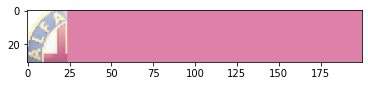

In [4]:
image, text = next(training_image_gen)
print('text:', text)
_ = plt.imshow(image)


Now we can run training.

In [10]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, restore_best_weights=False),
    tf.keras.callbacks.ModelCheckpoint('recognizer_borndigital.h5', monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.CSVLogger('recognizer_borndigital.csv')
]
recognizer.training_model.fit_generator(
    generator=training_gen,
    steps_per_epoch=training_steps,
    validation_steps=validation_steps,
    validation_data=validation_gen,
    callbacks=callbacks,
    epochs=100,
)

Epoch 1/100
  1/356 [..............................] - ETA: 47s - loss: 0.0306

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


356/356 [==============================] - 34s 95ms/step - loss: 0.6493 - val_loss: 1.5559
Epoch 2/100
356/356 [==============================] - 34s 95ms/step - loss: 0.6740 - val_loss: 1.7589
Epoch 3/100
356/356 [==============================] - 33s 93ms/step - loss: 0.5689 - val_loss: 1.8343
Epoch 4/100
356/356 [==============================] - 33s 94ms/step - loss: 0.5525 - val_loss: 1.6029
Epoch 5/100
356/356 [==============================] - 33s 94ms/step - loss: 0.5290 - val_loss: 2.4608
Epoch 6/100
356/356 [==============================] - 33s 94ms/step - loss: 0.5096 - val_loss: 2.3270
Epoch 7/100
356/356 [==============================] - 33s 93ms/step - loss: 0.4947 - val_loss: 1.6586
Epoch 8/100
356/356 [==============================] - 33s 93ms/step - loss: 0.4097 - val_loss: 1.8265
Epoch 9/100
356/356 [==============================] - 33s 94ms/step - loss: 0.3557 - val_loss: 2.1363
Epoch 10/100
356/356 [==============================] - 33s 94ms/step - loss: 0.4058 

Finally, run inference on a test sample.

Predicted: today, Actual: today


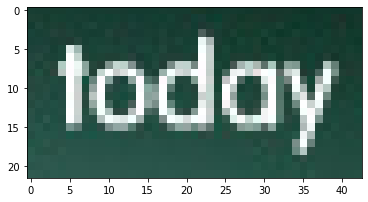

In [7]:
image_filepath, _, actual = test_labels[1]
predicted = recognizer.recognize(image_filepath)
print(f'Predicted: {predicted}, Actual: {actual}')
_ = plt.imshow(keras_ocr.tools.read(image_filepath))

In [8]:
recognizer.model.load_weights('recognizer_borndigital.h5')

Predicted: today, Actual: today


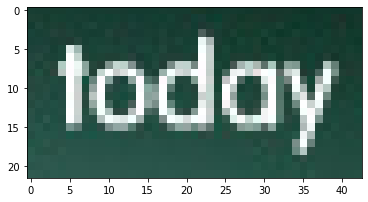

In [9]:
image_filepath, _, actual = test_labels[1]
predicted = recognizer.recognize(image_filepath)
print(f'Predicted: {predicted}, Actual: {actual}')
_ = plt.imshow(keras_ocr.tools.read(image_filepath))